In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import copy
import random
import importlib
import algos as al
import imageio

In [29]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

In [30]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        else:
            print(f"Edge {edge} not found in the graph.")

In [31]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

In [32]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

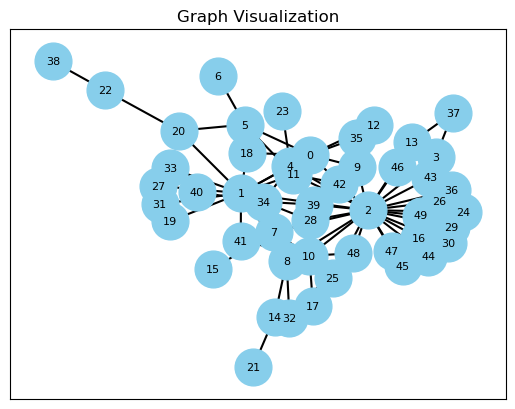

In [33]:
G = generate_sf_graph(50)
visualize_graph(G)

In [34]:
def probabilistic_walk(graph):
    visited_edges = set()
    walked_edges = []
    nodes = list(graph.nodes())

    # Compute PageRank
    pagerank_scores = nx.pagerank(graph)

    current_node = random.choice(nodes)
    while len(visited_edges) < graph.number_of_edges():
        neighbors = list(graph.neighbors(current_node))
        
        if not neighbors:
            print("No available neighbors")
            break

        # Compute probability using edge weight and PageRank
        weights = [
            pagerank_scores[neighbor] 
            for neighbor in neighbors
        ]

        # Normalize probabilities
        total_weight = sum(weights)
        if total_weight == 0:
            print("Encountered zero total weight")
            break

        probabilities = [w / total_weight for w in weights]

        next_node = random.choices(neighbors, weights=probabilities)[0]
        edge = (min(current_node, next_node), max(current_node, next_node))

        visited_edges.add(edge)
        walked_edges.append(edge)

        # Update edge weight
        graph[current_node][next_node]['weight'] = np.sqrt(graph[current_node][next_node]['weight'])

        current_node = next_node

    return walked_edges

In [8]:
def initialize_edge_weights(graph):
    """Set all edge weights to 0 for visualization."""
    for u, v in graph.edges():
        graph[u][v]['weight'] = 0

In [9]:
def get_highest_degree_node(graph):
    """Return the node with the highest degree in the graph."""
    degrees = dict(graph.degree())
    return max(degrees, key=degrees.get)

In [10]:
def multiple_probabilistic_walks(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    pagerank_scores = nx.pagerank(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/pagerank_scores[neighbor] + 0.000000001
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    return snapshots 

In [62]:
def visualize_graph(snapshot, ax, max_weight, starting_node=None):
    """Visualize a single snapshot of the graph with edge opacity and color based on current weight."""
    ax.clear()  # Clear the previous frame
    pos = nx.spring_layout(snapshot, seed=42, weight=None)  # Fixed layout for consistency
    
    # Get edge weights for the current snapshot
    edge_weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])

    # Create a colormap for edge weights
    cmap = plt.cm.plasma
    min_weight = 0.1  # Minimum weight to ensure edges are visible
    weight_factor = 3  # Adjust this factor to enhance color intensity
    
    # Minimum and maximum opacity values
    min_opacity = 0.1  # Set a minimum opacity for visibility
    max_opacity = 1.0  # Fully opaque for the highest weights

    # Scale weights for color mapping
    edge_weights = np.maximum(edge_weights, min_weight)  # Avoid weights below minimum
    
    # Normalize edge weights for color and opacity calculation
    scaled_weights = edge_weights * weight_factor  # Scale weights for color mapping
    
    # Calculate opacity based on edge weights relative to max weight in the last snapshot
    opacities = min_opacity + (edge_weights / max_weight) * (max_opacity - min_opacity)
    
    # Get colors from the colormap and apply opacity
    edge_colors = [(*cmap(weight / max_weight)[:3], opacity) 
                   for weight, opacity in zip(scaled_weights, opacities)]

    # Draw edges with colors and transparency based on weights
    nx.draw_networkx_edges(snapshot, pos, edge_color=edge_colors, width=2, ax=ax)

    # Draw nodes, differentiating the starting node with a different color
    node_colors = ['red' if node == starting_node else 'skyblue' for node in snapshot.nodes()]
    nx.draw_networkx_nodes(snapshot, pos, node_color=node_colors, node_size=100, ax=ax)

    # Turn off the axis
    plt.axis('off')


In [63]:
def animate_walks(snapshots, save_gif=True, filename="multiple_walks.gif", fps=5):
    """Animate the snapshots of graph walks and save as a GIF if desired."""
    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='#3e3e3e')
    last_snapshot = snapshots[-1]
    max_weight = max([last_snapshot[u][v]['weight'] for u, v in last_snapshot.edges()])
    starting_node = get_highest_degree_node(snapshots[0]) 
    
    # Update function to visualize each snapshot
    def update(frame):
        ax.clear()  # Clear the previous frame
        visualize_graph(snapshots[frame], ax, max_weight,starting_node)  # Visualize the current snapshot
        plt.title(f"Frame {frame + 1}", color='white')  # Update title with current step number
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(snapshots), interval=300, repeat=False)

    # Show or save the animation
    if save_gif:
        writer = PillowWriter(fps=fps)
        ani.save(filename, writer=writer)
        print(f"Animation saved as {filename}")
    else:
        plt.show()

Graph with 200 nodes and 248 edges


KeyboardInterrupt: 

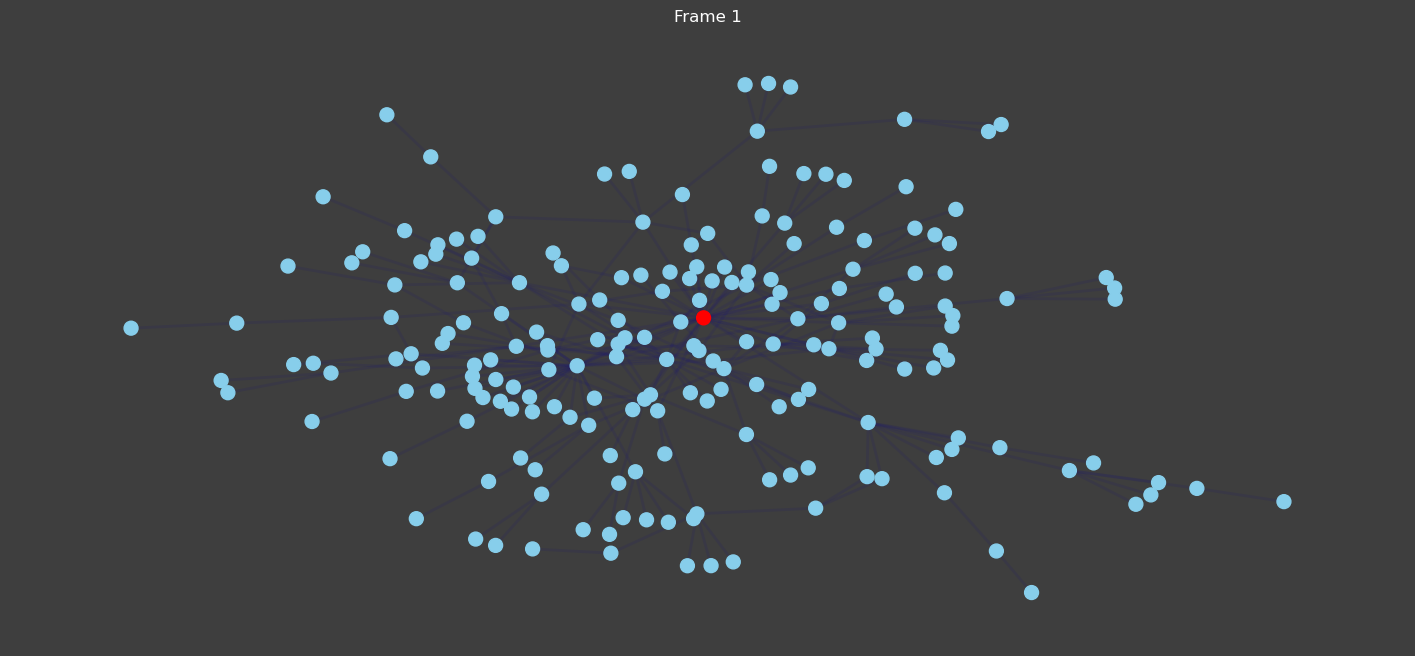

In [64]:
G = al.generate_sf_graph(200)
snapshots = multiple_probabilistic_walks(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="pageRanke_new.gif",fps=37)

In [11]:
def multiple_probabilistic_walks_betweenness(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    bc_centralities = nx.betweenness_centrality(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/(bc_centralities[neighbor] +0.0000001)
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    
    return snapshots 

Graph with 200 nodes and 253 edges
Animation saved as betweenness_new.gif


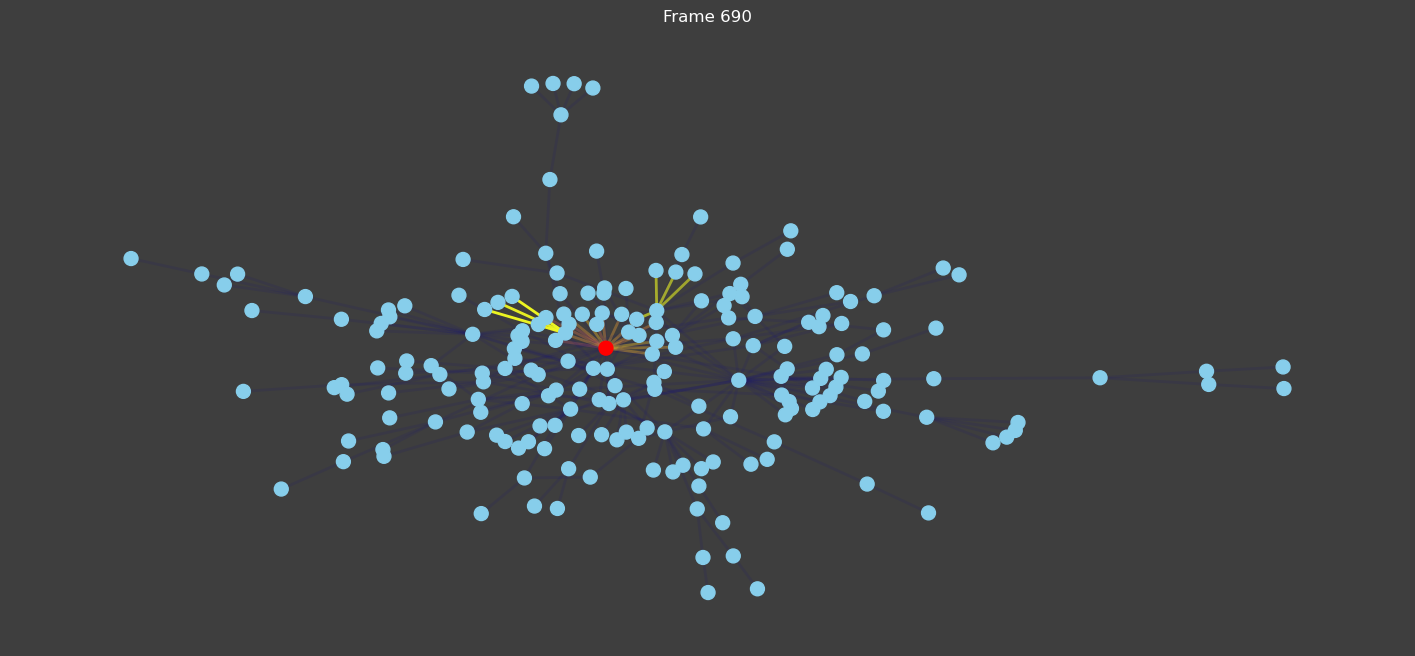

In [ ]:
G = al.generate_sf_graph(200)
snapshots = multiple_probabilistic_walks_betweenness(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="betweenness_new.gif",fps=37)

In [12]:
def multiple_probabilistic_walks_degree(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    dc_centralities = nx.degree_centrality(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/(dc_centralities[neighbor])
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    
    return snapshots 

Graph with 200 nodes and 259 edges
Animation saved as degree_new.gif


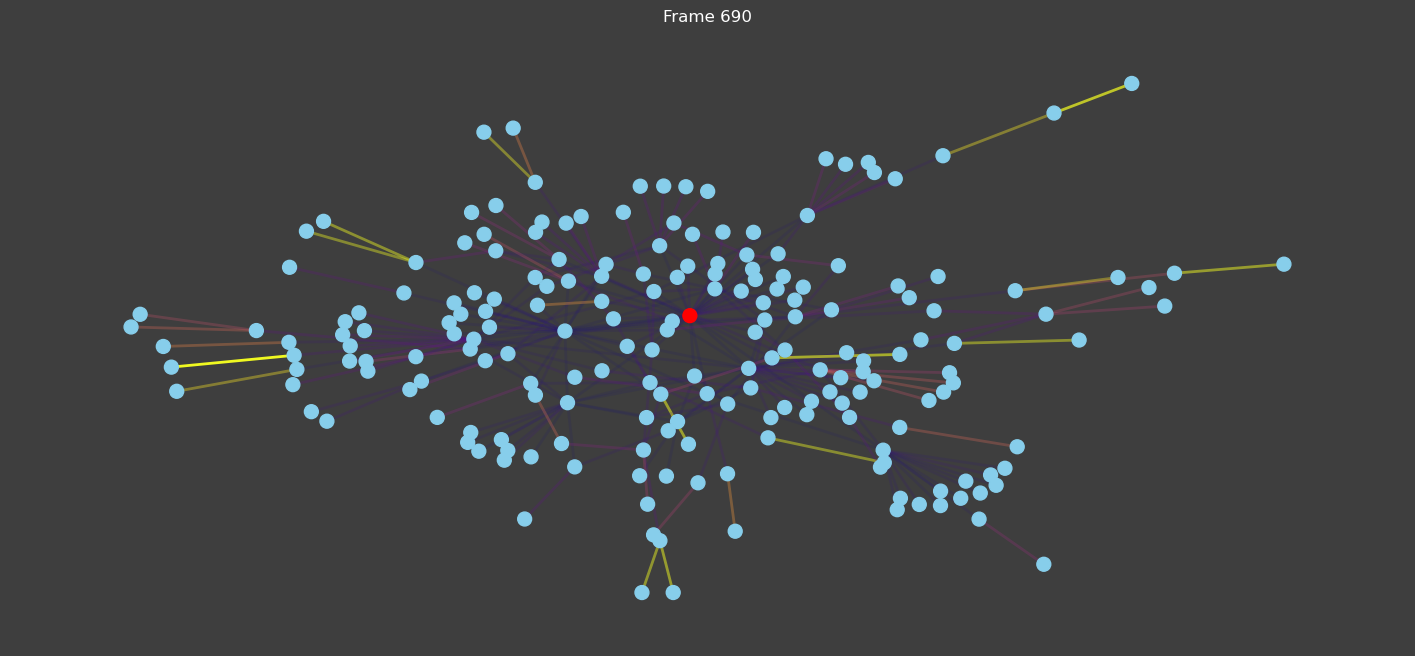

In [57]:
G = al.generate_sf_graph(200)
snapshots = multiple_probabilistic_walks_degree(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="degree_new.gif",fps=37)

In [58]:
G = al.generate_sf_graph(300)
PR = copy.deepcopy(G)
Degree = copy.deepcopy(G)
Between = copy.deepcopy(G)



snapshots_PR = multiple_probabilistic_walks(PR, 15, 650)
snapshots_Degree = multiple_probabilistic_walks_degree(Degree, 15, 650)
snapshots_betwwnness = multiple_probabilistic_walks_betweenness(Between, 15, 650)

Graph with 300 nodes and 372 edges
Graph with 300 nodes and 372 edges
Graph with 300 nodes and 372 edges


In [69]:
print(len(snapshots_PR))

740


In [13]:
def compute_std_devs(snapshots):
    std_devs = []
    for snapshot in snapshots:
        # Extract edge weights
        weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])
        std_devs.append(np.std(weights))
    return std_devs

[0.2762807969031259, 0.5525615938062518, 0.7250444028169526, 0.9365955574811597, 1.1021472593709443, 1.301597247111076, 1.5074750155972794, 1.7237199727831745, 1.9454993999911534, 2.1846951320445585, 2.4262312671378186, 2.6805267626506097, 2.8562242248734737, 3.04687907172189, 3.2432358436330664, 3.4474399455663485, 3.668450792566502, 3.8965218354517046, 4.096501663105215, 4.304931067388945, 4.488415833113832, 4.681023824378402, 4.872304968478671, 5.068247375600803, 5.271901527557944, 5.4858393051942524, 5.680108799087939, 5.88002963647643, 6.082835591324061, 6.292948169986406, 6.488565210786099, 6.689070921167964, 6.8756877750131915, 7.069700312201062, 7.259786235456938, 7.4559871720900315, 7.650457820029642, 7.852575240766392, 8.05475888230669, 8.260584292990572, 8.453583914058118, 8.65234515355582, 8.865277989595873, 9.082215911054535, 9.283498137506934, 9.487422530082023, 9.692990385242009, 9.902542794561757, 10.099076698198079, 10.30031621106201, 10.499592224049206, 10.70078332589

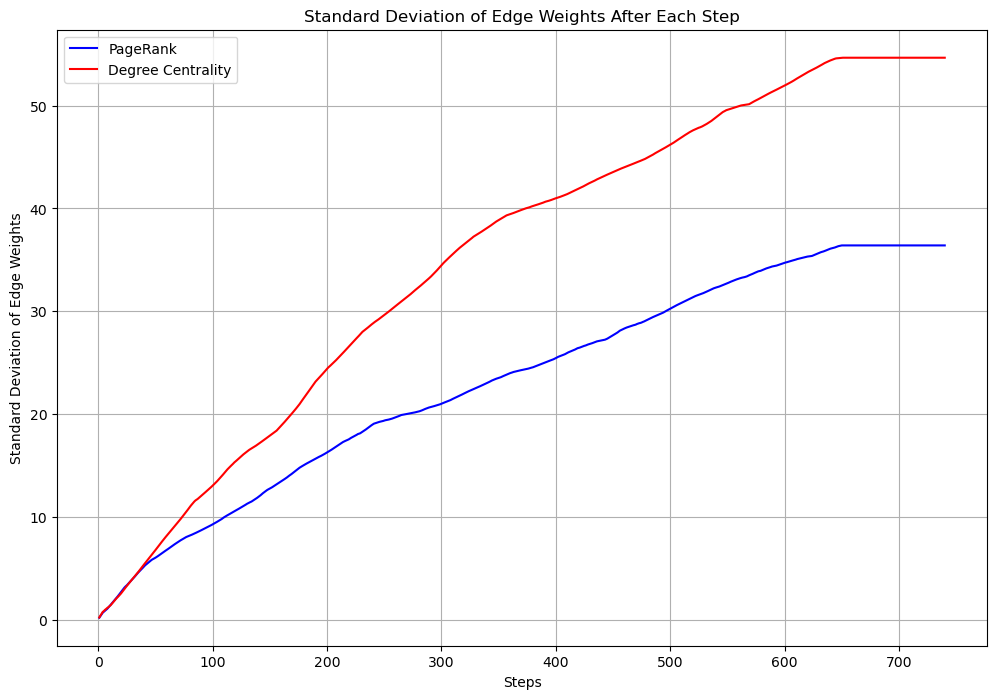

In [68]:
std_devs_PR = compute_std_devs(snapshots_PR)
std_devs_Degree = compute_std_devs(snapshots_Degree)
std_devs_betwwnness = compute_std_devs(snapshots_betwwnness)

print(std_devs_betwwnness)
#std_devs_Max = compute_std_devs(snapshots_Max)

# Plotting the standard deviations
plt.figure(figsize=(12, 8))
steps = range(1, 741)  # Adjust for the number of steps

plt.plot(steps, std_devs_PR, label='PageRank', linestyle='-', color='b')
plt.plot(steps, std_devs_Degree, label='Degree Centrality', linestyle='-', color='r')
#plt.plot(steps, std_devs_betwwnness, label='Combined', linestyle='-', color='g')
#plt.plot(steps, std_devs_Max, label='Max', linestyle='-', color='black')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Standard Deviation of Edge Weights')
plt.title('Standard Deviation of Edge Weights After Each Step')
plt.legend()
plt.grid()
plt.show()

In [14]:
def multiple_probabilistic_walks_combined(graph, num_walks, steps, alpha=1.0, beta=1.0):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on

    # Compute centrality measures
    dc_centralities = nx.degree_centrality(graph)
    pagerank_scores = nx.pagerank(graph)

    starting_node = get_highest_degree_node(graph)  # Start from highest degree node

    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = []
            
            for neighbor in neighbors:
                combined_score = alpha * dc_centralities[neighbor] + beta * pagerank_scores[neighbor]
                if combined_score != 0:
                    weights.append(1 / combined_score)
                else:
                    print(combined_score)
                    weights.append(0.0000001)  # Avoid division by zero
            

            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]

            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge

            current_node = next_node

    # Generate snapshots
    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []

    for edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)

    

    return snapshots

In [15]:

# Define ranges for alpha_degree and alpha_pagerank
alpha_degree_range = np.linspace(start = -10, stop=11,num=40)  # Adjust the range and step size as needed
alpha_pagerank_range = np.linspace(start = -1000, stop=1100,num=40)
steps = 400

In [16]:
##### rossz #####


std_devs = []
graph = al.generate_sf_graph(300)  # Generate a scale-free graph


# Iterate over combinations of alpha_degree and alpha_pagerank
for alpha_degree in alpha_degree_range:
    for alpha_pagerank in alpha_pagerank_range:
        print("degree weight: ", alpha_degree, " page rank weight: ", alpha_pagerank)
        graph_copy = copy.deepcopy(graph)  # Work on a fresh copy of the graph

        # Modify edge weights dynamically
        
        # Run the probabilistic walk
        snapshots = multiple_probabilistic_walks_combined(graph_copy, 15, 400,alpha=alpha_degree,beta=alpha_pagerank)
        final_snapshot = snapshots[-1]  # Snapshot after 400 steps
        
        # Compute standard deviation of edge weights
        edge_weights = [final_snapshot[u][v]['weight'] for u, v in final_snapshot.edges()]
        std_dev = np.std(edge_weights)
        
        # Store results
        std_devs.append((alpha_degree, alpha_pagerank, std_dev))

degree weight:  -10.0  page rank weight:  -1000.0
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -946.1538461538462
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -892.3076923076923
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -838.4615384615385
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -784.6153846153846
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -730.7692307692307
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -676.9230769230769
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -623.0769230769231
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -569.2307692307693
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -515.3846153846154
Graph with 300 nodes and 364 edges
degree weight:  -10.0  page rank weight:  -461.5384

In [19]:
import plotly.graph_objects as go
import numpy as np

# Extract values
alpha_degree_vals, alpha_pagerank_vals, std_dev_vals = zip(*std_devs)
std_dev_vals = np.array(std_dev_vals)  # Convert to NumPy array for processing

# Compute IQR (Interquartile Range)
Q1 = np.percentile(std_dev_vals, 25)  # 25th percentile
Q3 = np.percentile(std_dev_vals, 75)  # 75th percentile
IQR = Q3 - Q1
upper_bound = Q3 + 0.5 * IQR  # Outlier threshold

# Filter out high anomalies
filtered_data = [
    (a_d, a_p, std_dev)
    for a_d, a_p, std_dev in zip(alpha_degree_vals, alpha_pagerank_vals, std_dev_vals)
    if std_dev <= upper_bound  # Keep only non-outliers
]

# Extract filtered values
alpha_degree_vals_f, alpha_pagerank_vals_f, std_dev_vals_f = zip(*filtered_data)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=alpha_degree_vals_f,
    y=alpha_pagerank_vals_f,
    z=std_dev_vals_f,
    mode='markers',
    marker=dict(
        size=5,
        color=std_dev_vals_f,  # Color by standard deviation values
        colorscale='Viridis',  # Color theme
        colorbar=dict(title="Standard Deviation")
    )
)])

# Add axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="Degree Centrality Parameter",
        yaxis_title="PageRank Parameter",
        zaxis_title="Standard Deviation of Edge Weights"
    ),
    title="Interactive 3D Plot of Standard Deviation After 400 Steps (Filtered)",
    width=1000,
    height=800
)

fig.show()


In [20]:
std_dev_array = np.array(std_dev_vals)

# Find the index of the minimum standard deviation
min_index = np.argmin(std_dev_array)
max_index = np.argmax(std_dev_array)

# Retrieve the corresponding parameters
min_alpha_degree = alpha_degree_vals[min_index]
min_alpha_pagerank = alpha_pagerank_vals[min_index]
min_std_dev = std_dev_array[min_index]

max_alpha_degree = alpha_degree_vals[max_index]
max_alpha_pagerank = alpha_pagerank_vals[max_index]
max_std_dev = std_dev_array[max_index]


# Output the results
print(f"Minimum Standard Deviation: {min_std_dev}")
print(f"Parameters at Minimum: alpha_degree = {min_alpha_degree}, alpha_pagerank = {min_alpha_pagerank}")
print(f"Maximum Standard Deviation: {max_std_dev}")
print(f"Parameters at Maximum: alpha_degree = {max_alpha_degree}, alpha_pagerank = {max_alpha_pagerank}")

Minimum Standard Deviation: 17.48255811326804
Parameters at Minimum: alpha_degree = 9.384615384615383, alpha_pagerank = -30.769230769230717
Maximum Standard Deviation: 281.0290788066016
Parameters at Maximum: alpha_degree = -10.0, alpha_pagerank = 23.076923076923094


In [21]:
def multiple_probabilistic_walks_uniform(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            
    
            # Normalize probabilities
            total_weight = len(neighbors)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [1 / total_weight for w in neighbors]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    
    
    return snapshots 

In [26]:
G = al.generate_sf_graph(300)
PR = copy.deepcopy(G)
Degree = copy.deepcopy(G)
Between = copy.deepcopy(G)
Combined = copy.deepcopy(G)
Uniform = copy.deepcopy(G)



snapshots_Uniform = multiple_probabilistic_walks_uniform(Uniform, 120, 650)
snapshots_PR = multiple_probabilistic_walks(PR, 120, 650)
snapshots_Degree = multiple_probabilistic_walks_degree(Degree, 120, 650)
snapshots_betwwnness = multiple_probabilistic_walks_betweenness(Between, 120, 650)
snapshots_Combined = multiple_probabilistic_walks_combined(Combined, 120, 650,alpha=9.38, beta=-30)

Graph with 300 nodes and 383 edges
Graph with 300 nodes and 383 edges
Graph with 300 nodes and 383 edges
Graph with 300 nodes and 383 edges
Graph with 300 nodes and 383 edges


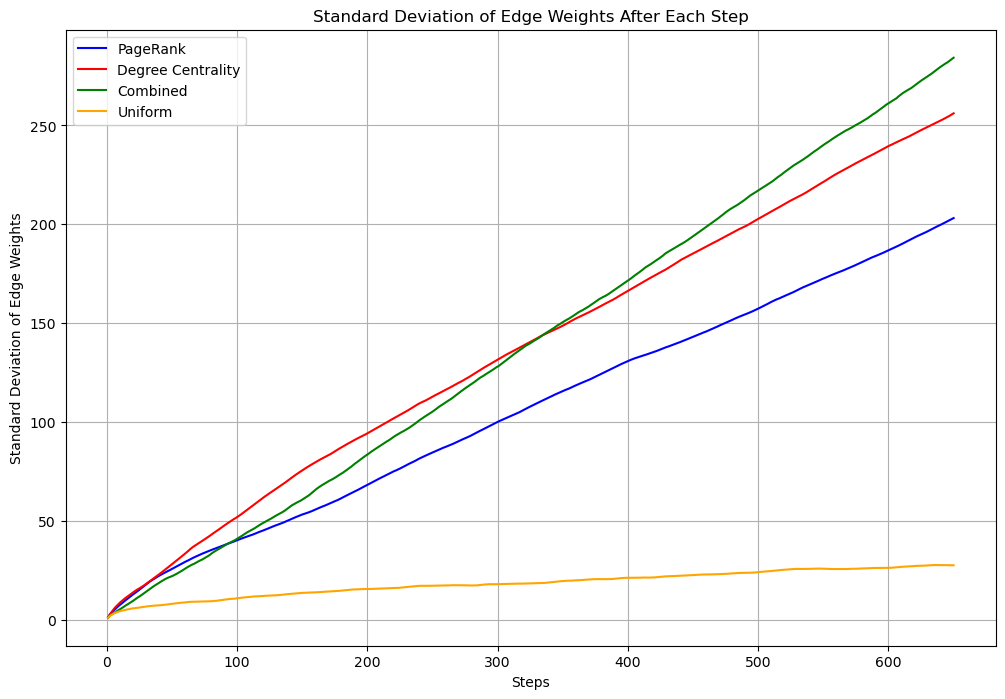

In [27]:
std_devs_PR = compute_std_devs(snapshots_PR)
std_devs_Degree = compute_std_devs(snapshots_Degree)
std_devs_Combined = compute_std_devs(snapshots_Combined)
std_devs_Uniform = compute_std_devs(snapshots_Uniform)
std_devs_Between = compute_std_devs(snapshots_betwwnness)
#std_devs_Max = compute_std_devs(snapshots_Max)

# Plotting the standard deviations
plt.figure(figsize=(12, 8))
steps = range(1, 651)  # Adjust for the number of steps

plt.plot(steps, std_devs_PR, label='PageRank', linestyle='-', color='b')
plt.plot(steps, std_devs_Degree, label='Degree Centrality', linestyle='-', color='r')
plt.plot(steps, std_devs_Combined, label='Combined', linestyle='-', color='g')
plt.plot(steps, std_devs_Uniform, label='Uniform', linestyle='-', color='orange')
#plt.plot(steps, std_devs_Between, label='Betweenness', linestyle='-', color='orange')
#plt.plot(steps, std_devs_Max, label='Max', linestyle='-', color='black')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Standard Deviation of Edge Weights')
plt.title('Standard Deviation of Edge Weights After Each Step')
plt.legend()
plt.grid()
plt.show()

In [117]:
G = nx.random_planar_graph(10)

# Draw the planar graph
nx.draw_planar(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

AttributeError: module 'networkx' has no attribute 'random_planar_graph'

In [2]:
def KMJ(v, f, i, min_edges):
    """
    Generates a planar scale-free graph using the KMJ method.
    
    v: Number of vertices
    f: Distribution function (callable)
    i: Number of iterations
    min_edges: Minimum number of edges before stopping
    """
    # Step 1: Create vertices
    G = nx.Graph()
    G.add_nodes_from(range(v))
    
    # Assign probabilities based on distribution function
    probabilities = f(v)
    probabilities /= probabilities.sum()  # Normalize to make it a probability distribution
    
    # Step 2: Add edges iteratively
    edge_count = 0
    iter = 0
    while iter <i or edge_count<min_edges:
        
        # Select first vertex based on probability distribution
        vertex1 = np.random.choice(range(v), p=probabilities)
        
        # Select second vertex purely randomly
        vertex2 = random.randint(0, v - 1)
        
        # Avoid self-loops
        if vertex1 == vertex2:
            continue
        
        # Add edge if planarity is preserved
        G.add_edge(vertex1, vertex2)
        if nx.check_planarity(G)[0]:  # Check if still planar
            edge_count += 1
        else:
            G.remove_edge(vertex1, vertex2)  # Revert if not planar
        iter+=1

    return G

In [31]:
import scipy.stats as stats
v = 50  # Number of vertices
i = 500  # Max iterations
min_edges = 20  # Minimum edges before stopping

def normal_distribution(v, mu=None, sigma=None):
    """
    Creates a normal distribution centered around mu with standard deviation sigma.
    """
    if mu is None:
        mu = v / 2  # Center around the middle vertex
    if sigma is None:
        sigma = v / 4  # Control spread

    x = np.arange(v)
    probabilities = stats.norm.pdf(x, loc=mu, scale=sigma)  # Normal PDF values
    return probabilities

# Generate the graph
G = KMJ(v, normal_distribution, i, min_edges)

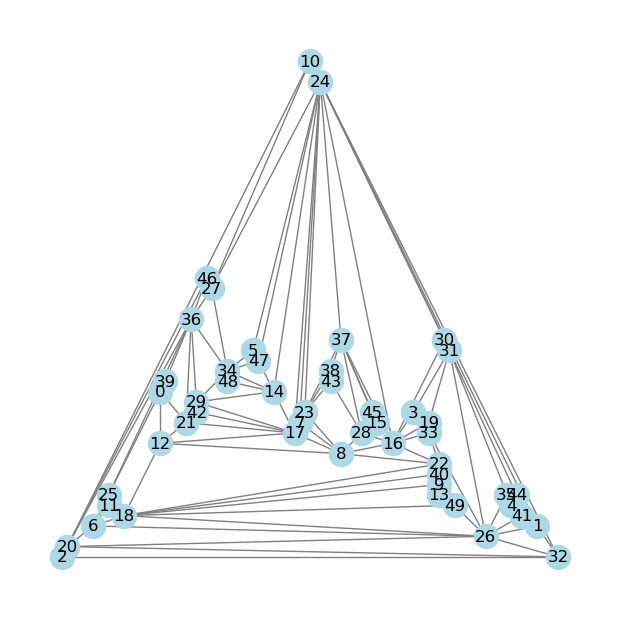

In [32]:
plt.figure(figsize=(6,6))
nx.draw_planar(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

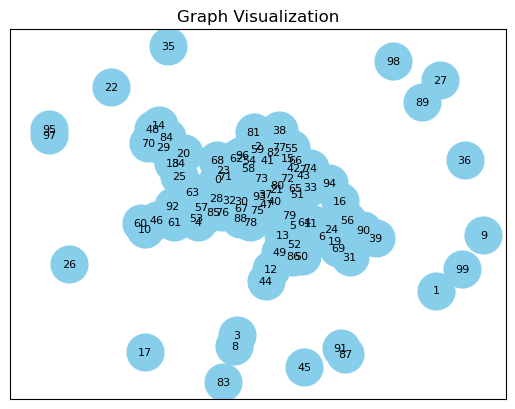

In [15]:
visualize_graph(G)

In [14]:
def visualize_graph_pretty(G, title="Graph Visualization", seed=42):
    plt.figure(figsize=(18,8), facecolor='#5e5e5e')
    ax = plt.gca()
    ax.set_facecolor('#5e5e5e')
    pos = nx.spring_layout(G, weight=None, seed=seed)  # You can use other layouts as well

    # Check if edges have weights
    if nx.get_edge_attributes(G, 'weight'):
        # If weights exist, use them for edge coloring
        edge_weights = np.array([G[u][v].get('weight', 1) for u, v in G.edges()])
        cmap = plt.cm.plasma
        norm_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())
        min_alpha = 0.1  # Minimum alpha for visibility
        alphas = norm_weights * (1 - min_alpha) + min_alpha
        edge_colors = [cmap(weight) for weight in norm_weights]
        edge_colors_with_alpha = [(r, g, b, a) for (r, g, b, _), a in zip(edge_colors, alphas)] # Use weights for edge coloring
    else:
        # If no weights, set all edges to the same color (e.g., gray)
        edge_colors_with_alpha = 'blue'
        edge_weights = None  # No weights present

    # Draw edges
    nx.draw_networkx_edges(
        G,
        pos,
        arrowsize=10,
        edge_color=edge_colors_with_alpha,
        width=2,
    )

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=min(5000/G.number_of_nodes(), 200))
    
    # If edge weights exist, create colorbar based on scalar values (not RGBA tuples)
    if edge_weights is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max()))
        sm.set_array([])  # Create an empty array for the ScalarMappable
        plt.colorbar(sm, label='Edge Weight', orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.title(title)
    plt.show()

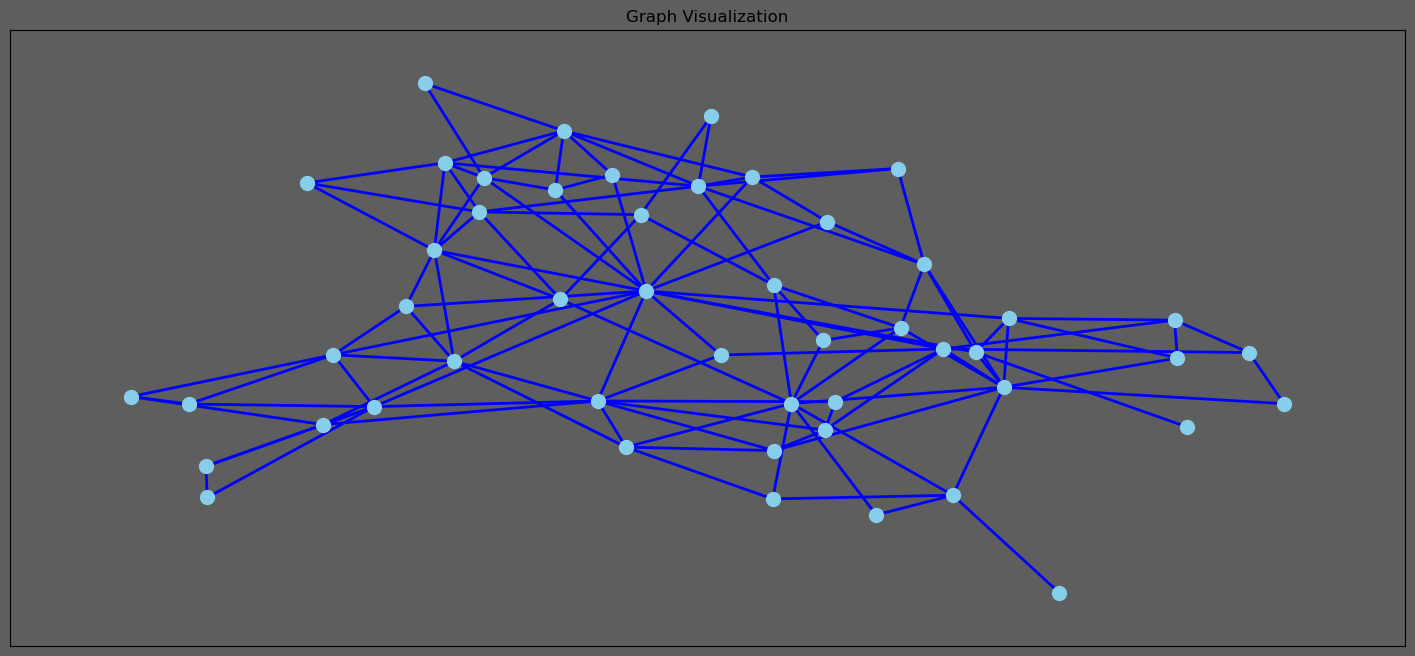

In [33]:
visualize_graph_pretty(G)

In [23]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = weight
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = weight
        else:
            print(f"Edge {edge} not found in the graph.")

In [34]:
SF = copy.deepcopy(G)
PR = copy.deepcopy(G)
DR = copy.deepcopy(G)


add_weights_to_edges_from_dict(SF,nx.betweenness_centrality(nx.line_graph(SF)))
add_weights_to_edges_from_dict(DR,nx.degree_centrality(nx.line_graph(DR)))
add_weights_to_edges_from_dict(PR,nx.pagerank(nx.line_graph(SF),max_iter=500))


C:\Users\Kocsis Máté\AppData\Local\Temp\ipykernel_2580\2619976664.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Edge Weight', orientation='vertical', fraction=0.046, pad=0.04)


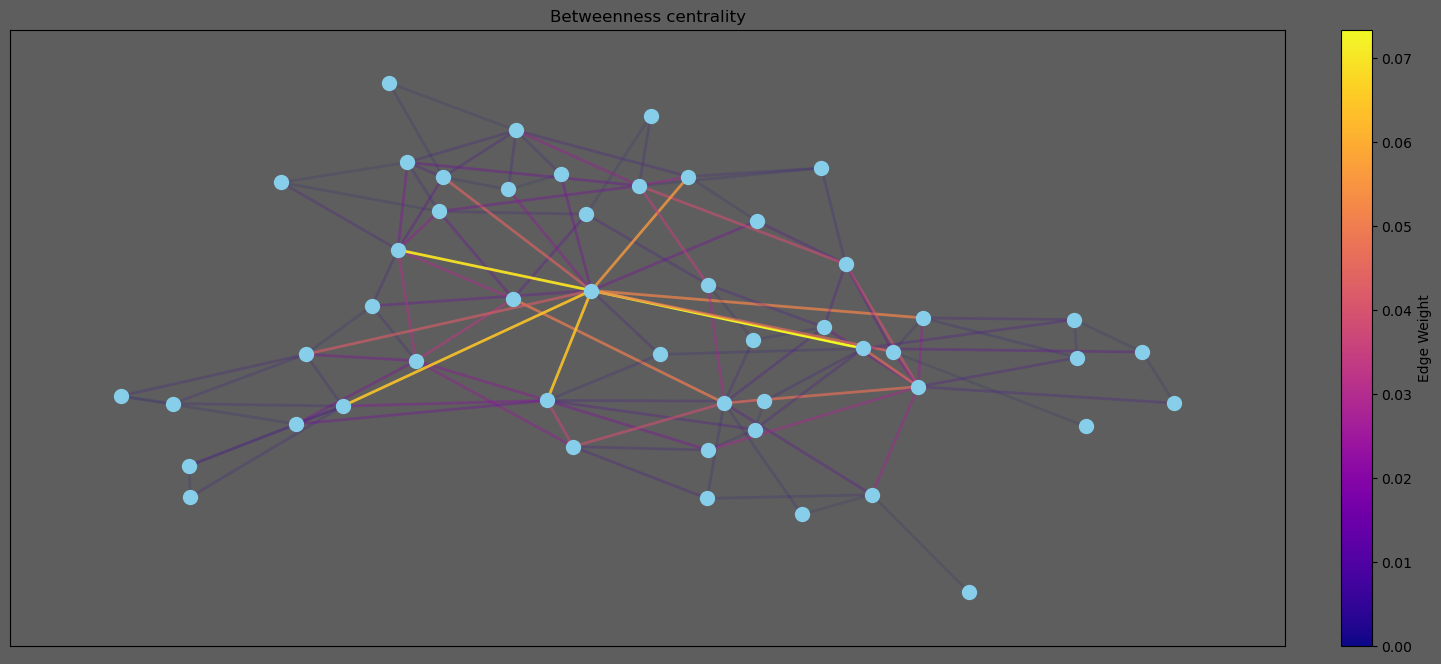

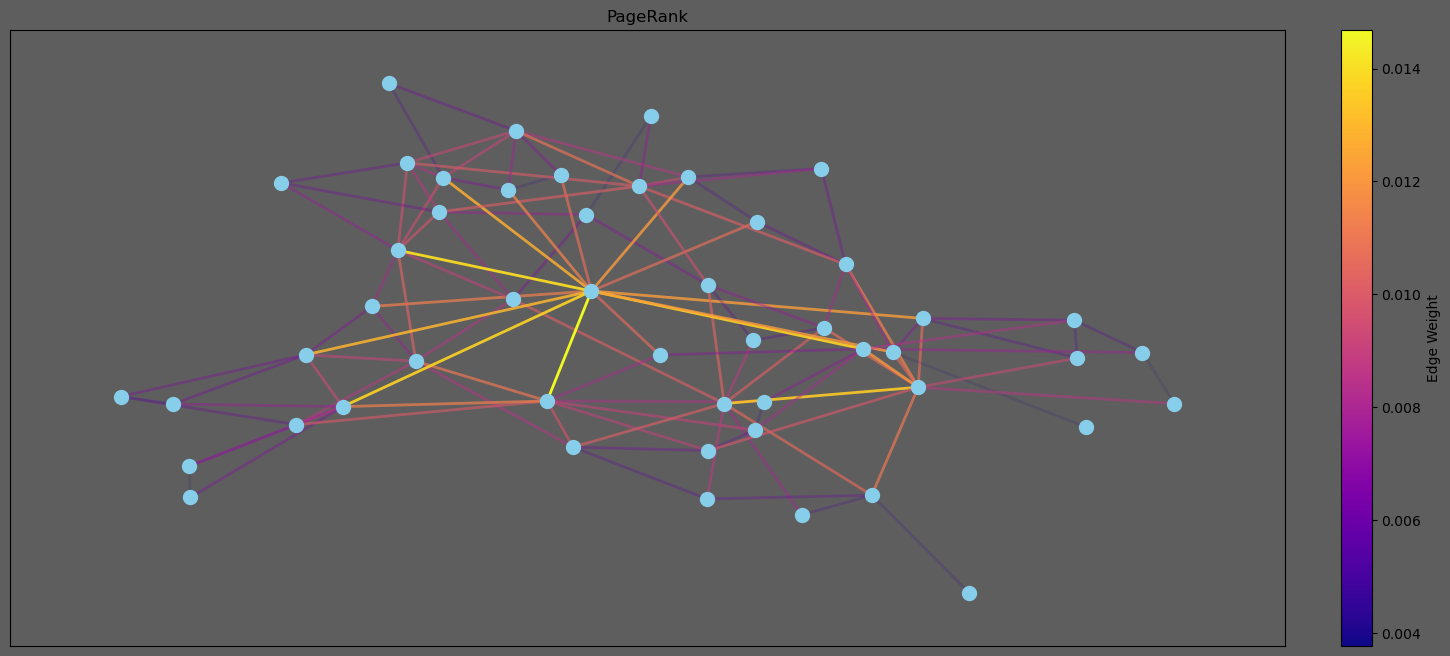

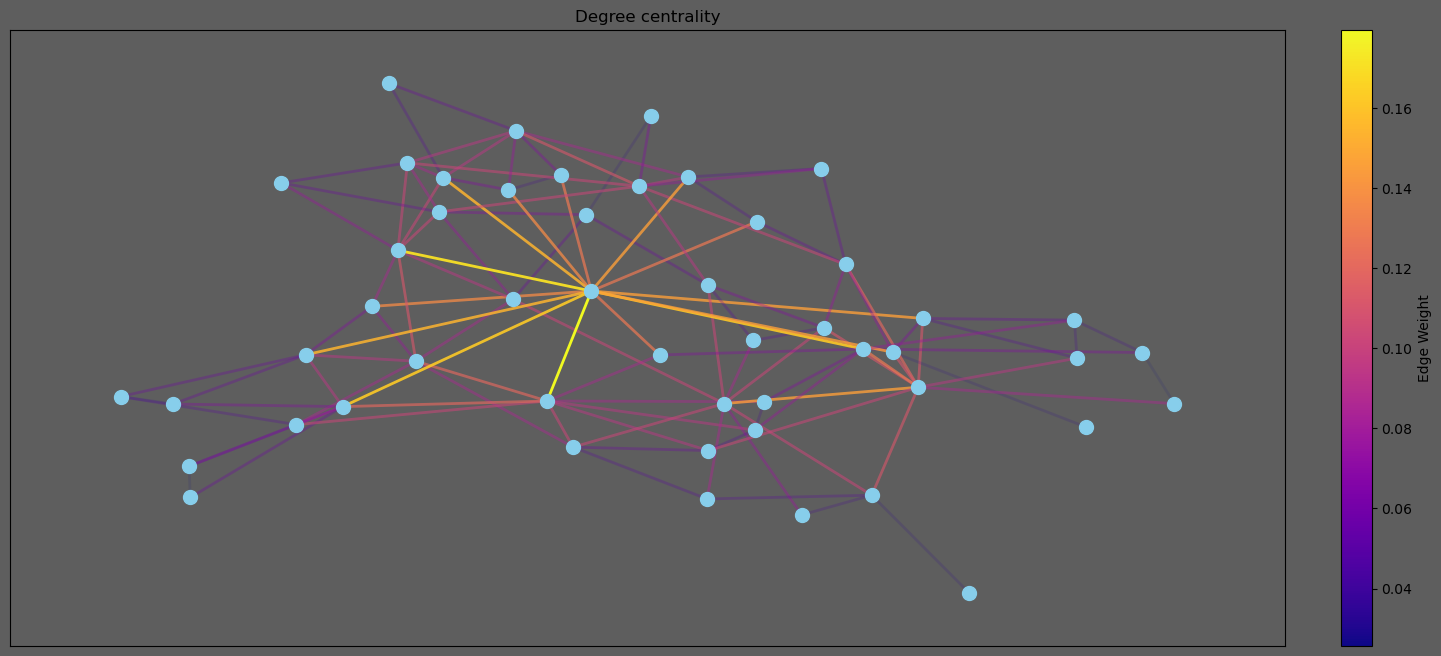

In [35]:
visualize_graph_pretty(SF, "Betweenness centrality")
visualize_graph_pretty(PR, "PageRank")
visualize_graph_pretty(DR, "Degree centrality")
